# Response criteria prediction for tumor
Sam Tomioka<br>
2019-10-03

This notebook is for PhUSE AI/ML Project Tumor response prediction challenge using 
- `dummyTGR` as a training and validation
- `tr_rs_final` is used for testing

Data provided by Priya Gopal.

## 1 - Import libraries

!conda install -c conda-forge xgboost -y
import xgboost
xgboost.__version__

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from xgboost import XGBClassifier
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split\
, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, normalize

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier

from lib import myutil
from matplotlib import pyplot as plt
from matplotlib import cm as cm
import seaborn as sns
%matplotlib inline

print('sklearn=={}\nxgboost=={}'.format(sklearn.__version__,xgb.__version__))

sklearn==0.20.3
xgboost==0.90


## 2 - Import data

In [2]:
traindf=pd.read_excel(os.path.join('..','data','dummyTGR.xlsx'))
traindf=traindf.iloc[:,0:8]
testdf=pd.read_excel(os.path.join('..','data','tr_rs_final.xls'))

print('Train: {}\nTest: {}'.format(traindf.shape, testdf.shape))

#update the name of the columns of test set. second column doesn't match
testdf.columns=traindf.columns.to_list()
# check for leak
check=pd.merge(traindf, testdf, how='inner', on=traindf.columns[:7].to_list())
print('Any leak? {}'.format(check.shape[0]))

Train: (9268, 8)
Test: (268, 8)
Any leak? 0


- class variable: `TARGET` 
- Other columns are features

## 3 - Check missing

In [3]:
for c in traindf.columns:
    print ('Number of missing in {}: {}'\
           .format(c, len(traindf[traindf[c].isnull()])))
for c in testdf.columns:
    print ('Number of missing in {}: {}'\
           .format(c, len(testdf[testdf[c].isnull()])))

Number of missing in SUMLDIAM: 0
Number of missing in SUMNLNLD: 0
Number of missing in SUMDIAM: 0
Number of missing in PCBSD: 0
Number of missing in NADIR: 0
Number of missing in ACNSD: 0
Number of missing in PCNSD: 0
Number of missing in TARGET: 0
Number of missing in SUMLDIAM: 0
Number of missing in SUMNLNLD: 0
Number of missing in SUMDIAM: 0
Number of missing in PCBSD: 0
Number of missing in NADIR: 0
Number of missing in ACNSD: 0
Number of missing in PCNSD: 0
Number of missing in TARGET: 0


## 4 - check distribution

### - class variable

In [4]:
dist=traindf['TARGET'].value_counts()/len(traindf['TARGET'])
dist

PD    0.316789
PR    0.306107
CR    0.247303
SD    0.129801
Name: TARGET, dtype: float64

In [5]:
dist=testdf['TARGET'].value_counts()/len(testdf['TARGET'])
dist

PD    0.343284
PR    0.317164
SD    0.291045
CR    0.048507
Name: TARGET, dtype: float64

In [6]:
n_class=4
weight_dict={'PD': (1/n_class)/dist[0]
            ,'PR': (1/n_class)/dist[1]
            ,'CR': (1/n_class)/dist[2] 
            ,'SD': (1/n_class)/dist[3]
            }
wt = traindf['TARGET'].map(weight_dict)

May need to adjust the imbalance

### - covariates (features)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c87c94c50>,
      dtype=object)

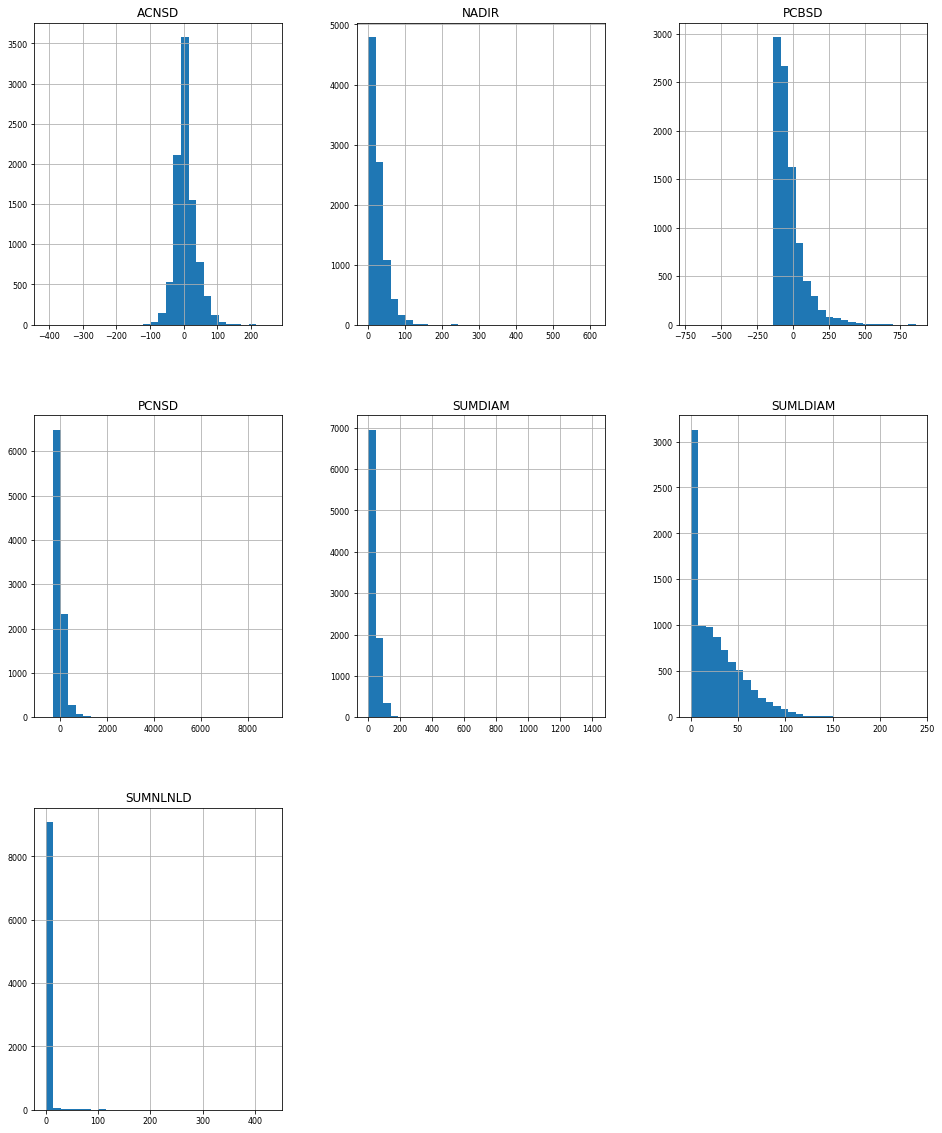

In [7]:
traindf.hist(figsize=(16, 20)
        , bins=30
        , xlabelsize=8
        , ylabelsize=8)

### - check for confounding

### - check for multicollinearity

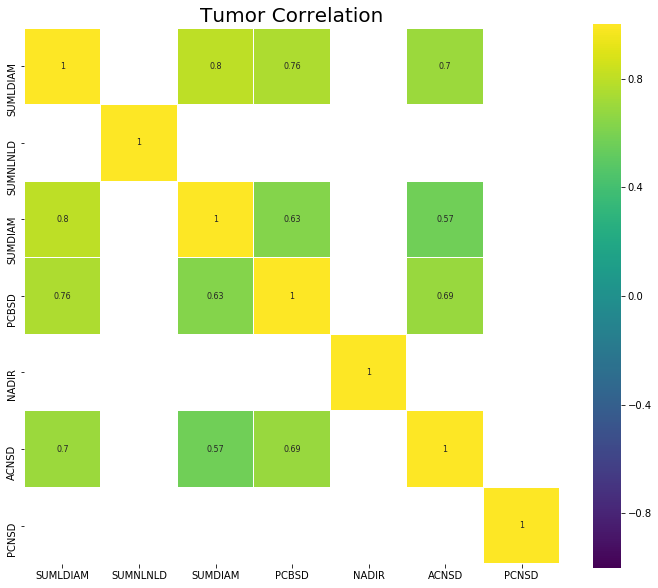

In [8]:
myutil.corr_matrix(traindf)

SUMLDAM dependent of PCBSD,
PCBSD looks dependent on SUMDIAM, but these are probably okay to keep

## 5. Pre-process

In [9]:
X_tr = np.array(traindf.iloc[:,0:7])
X_ts = np.array(testdf.iloc[:,0:7])
y_tr = np.array(traindf.iloc[:,7:8]).ravel()
y_ts = np.array(testdf.iloc[:,7:8]).ravel()

scale

```
#not suitable for this data
minmaxscl=MinMaxScaler((0,1))
X_tr = minmaxscl.fit_transform(X_tr)
X_ts = minmaxscl.fit_transform(X_ts)```

In [10]:
X_tr=normalize(X_tr,norm='l2', axis=1)
X_ts=normalize(X_ts,norm='l2', axis=1)

## 6.  train/evaluate cv results

### random forest

In [11]:
%%time
#grid_param = {
#    'n_estimators': np.arange(2000, 3000, 500)
#    , 'criterion': ['gini', 'entropy']
#    , 'bootstrap': [True, False]
#    , 'max_depth': np.arange(13,15,1)
#}
#rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=2019)
#                     , param_distributions=grid_param
#                     , scoring='accuracy'
#                     , n_iter=15
#                     , cv=10
#                     , n_jobs=-1)
#rf.fit(X_tr, y_tr)
#
#print('Best Model\nParameters: {}\n       Acc: {}'.format(rf.best_params_,rf.best_score_))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


In [12]:
rfclf=RandomForestClassifier(class_weight=weight_dict
                           , random_state=2019
                           , n_estimators=2000
                           , criterion='entropy'
                           , max_depth=13
                           , bootstrap=False).fit(X_tr,y_tr)


In [13]:
pickle.dump(rfclf, open('../models/rf_nosplit-model.sav', 'wb'))
rfclf = pickle.load(open('../models/rf_nosplit-model.sav', 'rb'))

### SVC

In [14]:
%%time
grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'gamma':stats.expon(scale=0.01)

}
lsvc = RandomizedSearchCV(estimator=SVC()
                  , param_distributions=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_iter=30
                  , n_jobs=-1)
lsvc.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(lsvc.best_params_,lsvc.best_score_))

Best Model
Parameters: {'C': 2.6063519229832663, 'gamma': 0.02281262276154987, 'tol': 0.001}
       Acc: 0.8987915407854985
CPU times: user 1.93 s, sys: 228 ms, total: 2.16 s
Wall time: 1min 51s


In [15]:
pickle.dump(lsvc.best_estimator_, open('../models/svc_nosplit-model.sav', 'wb'))
svcclf = pickle.load(open('../models/svc_nosplit-model.sav', 'rb'))

### logistic regression

In [16]:
%%time
grid_param = {
    'tol': [1e-3,1e-4]
    , 'C': stats.expon(scale=1)
    , 'solver': ['lbfgs','saga','newton-cg']
    , 'max_iter':[1000, 2000]
}
lr = RandomizedSearchCV(estimator=LogisticRegression(penalty='l2',
                                               multi_class='multinomial')
                  , param_distributions=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_iter=30
                  , n_jobs=-1)
lr.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(lr.best_params_,lr.best_score_))

Best Model
Parameters: {'C': 4.609511843750691, 'max_iter': 2000, 'solver': 'saga', 'tol': 0.001}
       Acc: 0.9196158826068191
CPU times: user 1.02 s, sys: 58.9 ms, total: 1.08 s
Wall time: 6.86 s


In [17]:
pickle.dump(lr.best_estimator_, open('../models/lr_nosplit-model.sav', 'wb'))
lrclf = pickle.load(open('../models/lr_nosplit-model.sav', 'rb'))

### knn

In [18]:
%%time
grid_param = {
            'weights': ['uniform','distance']
            , 'p': [1,2]
            , 'leaf_size': np.arange(10,50,5)
}
kn = GridSearchCV(estimator=KNeighborsClassifier(n_neighbors = 4
                                                 ,algorithm ='auto')
                  , param_grid=grid_param
                  , scoring='accuracy'
                  , cv=10
                  , n_jobs=-1)
kn.fit(X_tr, y_tr)

print('Best Model\nParameters: {}\n       Acc: {}'.format(kn.best_params_,kn.best_score_))

Best Model
Parameters: {'leaf_size': 10, 'p': 1, 'weights': 'distance'}
       Acc: 0.9677384548985758
CPU times: user 611 ms, sys: 18.1 ms, total: 629 ms
Wall time: 3.09 s


In [19]:
pickle.dump(kn.best_estimator_, open('../models/kn_nosplit-model.sav', 'wb'))
knclf = pickle.load(open('../models/kn_nosplit-model.sav', 'rb'))

### xgboost

In [20]:
#%%time
#grid_param = {
#        'colsample_bytree': np.arange(0.1,1.5,0.1)
#        #,'min_child_weight': np.arange(4,8,2)
#        ,'gamma': np.arange(0,3,.5)
#        ,'colsample_bytree': [0.4, 0.8, 0.1]
#        ,'max_depth': np.arange(8,14,1)
#        #,'learning_rate': [0.01,0.1]
#        #,'n_estimators': [1000, 800]
#
#        }
#
#skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2019)
#xg = RandomizedSearchCV(XGBClassifier(objective='multi:softprob'
#                                          , silent=True
#                                          , nthread=-1
#                                          , n_estimators=2000
#                                          , learning_rate=0.01
#                                          , min_child_weight=1
#                                        
#                                          )
#                                      , param_distributions=grid_param
#                                      , n_iter=20
#                                      , scoring='accuracy'
#                                      , n_jobs=-1
#                                      , cv=skf.split(X_tr,y_tr)
#                                      , verbose=3
#                                      , random_state=2019)
#
#xg.fit(X_tr, y_tr)
#
#print('Best Model\nParameters: {}\n       Acc: {}'.format(xg.best_params_,xg.best_score_))

In [21]:
xgclf=XGBClassifier(objective='multi:softprob'
                                          , silent=True
                                          , nthread=-1
                                          , n_estimators=2000
                                          , min_child_weight=1
                                          , max_depth=9
                                          , learning_rate=0.01
                                          , gamma=0
                                          , colsample_bytree=0.6
                 ).fit(X_tr,y_tr)


In [22]:
pickle.dump(xgclf, open('../models/xg_nosplit-model.sav', 'wb'))
xgclf = pickle.load(open('../models/xg_nosplit-model.sav', 'rb'))

In [86]:
%%time
models = [
          lsvc.best_estimator_
          , lr.best_estimator_
          ,  rfclf
          , kn.best_estimator_
          , xgclf
]


entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_tr, y_tr, scoring='accuracy', cv=10)
    for idx, accuracy in enumerate(accuracies):
        entries.append((model_name, idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model name', 'idx', 'accuracy'])

CPU times: user 46min 29s, sys: 1.94 s, total: 46min 31s
Wall time: 11min 27s


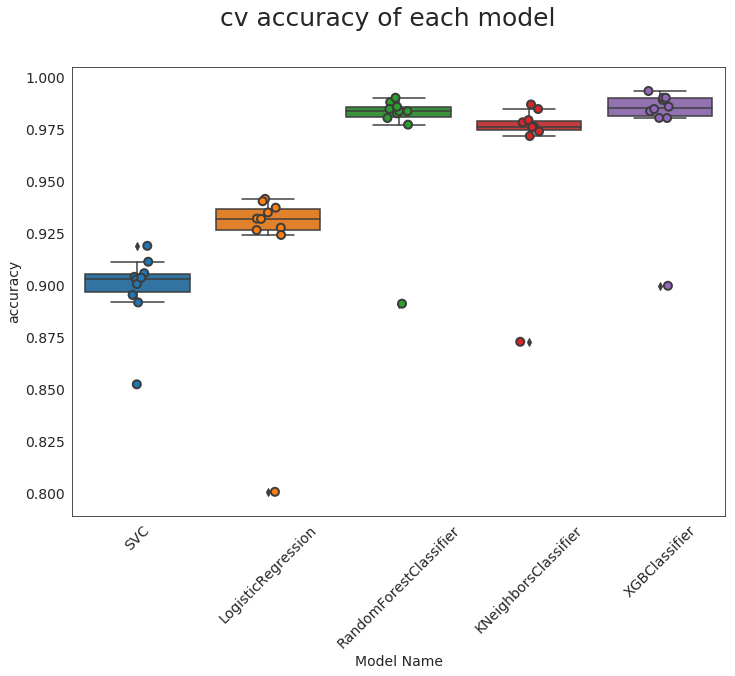

In [87]:
myutil.plot_model_performance(cv_df, t='cv')

## 7. test

In [105]:
entries = []
pred_lst=[]
for model in models:
    model_name = model.__class__.__name__
    clf=model.fit(X_tr,y_tr)
    y_pred=clf.predict(X_ts)
    acc=accuracy_score(y_ts, y_pred)
    entries.append((model_name, acc))
    pred_lst.append(y_pred)

pred4ensemble=pred_lst[2:5]

## 8. Build ensemble and testing ensemble model

In [106]:
def ensemble_m(p):
    pred=[]
    c=[]
    for i in range(len(np.array(p).T)):
        unique, counts = np.unique(np.array(p).T[i], return_counts=True)
        idx=list(counts).index(counts.max())
        pred.append(list(unique)[idx])
        c.append(counts)
    return pred

y_pred=ensemble_m(pred4ensemble)

acc=accuracy_score(y_ts, y_pred)
entries.append(('ensemble', acc))

test_df = pd.DataFrame(entries, columns=['model name', 'accuracy'])

In [107]:
test_df

,model name,accuracy
0,SVC,0.764925
1,LogisticRegression,0.768657
2,RandomForestClassifier,0.925373
3,KNeighborsClassifier,0.932836
4,XGBClassifier,0.910448
5,ensemble,0.929104


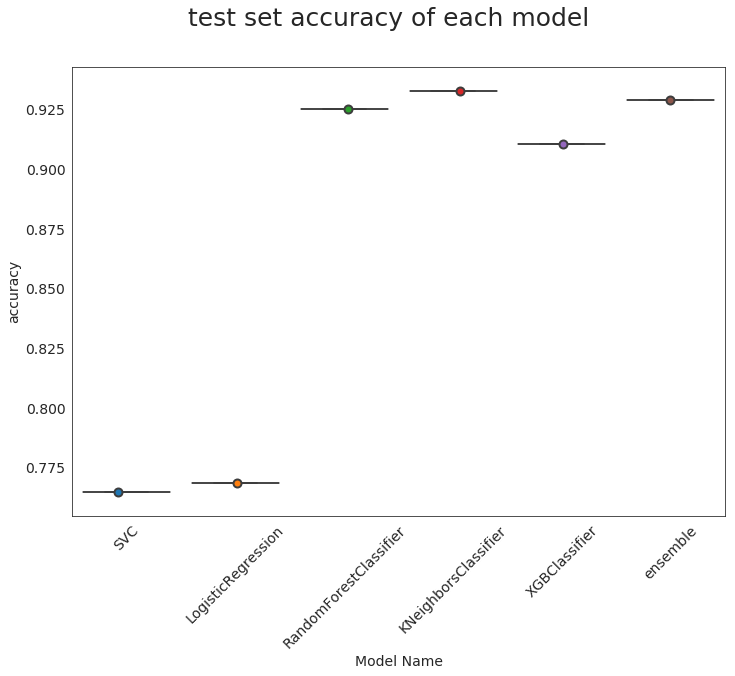

In [108]:
myutil.plot_model_performance(test_df, 'test set')

## Summary



knn was the best model with over 93% accuracy. Ensemble model did not perform better than knn. RF and XGB were over fit, but not had chance to tune the hyperparameters.